# Global Fairness Verification example

Based on Calzavara et al. Explainable Global Fairness Veriﬁcation of Tree-Based Classiﬁers" (2022).

This example focuses on fairness that expresses (a lack of) causal discrimination. It is a global fairness (or verification of global robustness) task which means that is does not rely on the choice of a specific test set, but (implicitly) ranges over all possible instances.

## Preliminaries

In [49]:
%load_ext autoreload
%autoreload 2

import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## German dataset

We will use the [German Credit Data](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data).

### Load the data

In [2]:
X_df, y_df = datasets.fetch_openml(data_id=31, return_X_y=True, as_frame=True)
X, yn = datasets.fetch_openml(data_id=31, return_X_y=True, as_frame=False)

Make the target numerical

In [3]:
y = (yn=='good').astype(int)

We will focus on sex as a relevant parameter, thus will split up column 9 (index 8) 'personal_status'.

In [4]:
# weird categories, so simplify to sex
featmap = [0, 1, 0, 0, 1]
X[:, 8] = [featmap[int(val)] for val in X[:, 8]]

Introduce bias: we can optionally introduce bias to make the effect easier to see.

In [5]:
introduce_bias = 100
if introduce_bias > 0:
    X[0:introduce_bias, :] = X[0, :]
    half_idx = int(introduce_bias/2)
    X[:half_idx, 8] = 0
    y[:half_idx] = 1
    X[half_idx:introduce_bias, 8] = 1
    y[half_idx:introduce_bias] = 0

Use train and test set

In [6]:
xtrain, xtest, ytrain, ytest, ytrain_n, ytest_n = train_test_split(X, y, yn, test_size=0.2, shuffle=True)

### Train the classifier

In [7]:
import veritas
import xgboost as xgb
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

The original paper uses 12 trees of depth 6.

In [32]:
n_estimators = 12 # 50
params = {
    "n_estimators": n_estimators,
    #"num_class": 10,
    #"objective": "multi:softmax",
    #"eval_metric": "merror",
    "eval_metric": "error",
    
    "tree_method": "hist",
    "seed": 135,
    "max_depth": 6,  # 7,
    "learning_rate": 0.5, #0.2,
    "colsample_bynode": 0.75,
    # "subsample": 0.5
}

# Slightly worse model (but faster verification, simpler model)
params["learning_rate"] = 0.2
params["subsample"] = 0.5

model = xgb.XGBClassifier(**params)

t = time.time()
model.fit(X, y)
print(f"XGB trained in {time.time()-t:.2f} seconds")

XGB trained in 0.01 seconds


In [33]:
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
acc_train = accuracy_score(ytrain, ytrain_pred)
acc_test = accuracy_score(ytest, ytest_pred)

print(f"Train acc: {acc_train:.3f}, test acc: {acc_test:.3f} wrt true labels")

Train acc: 0.870, test acc: 0.865 wrt true labels


### Global fairness

The features sex is considered sensitive. Who are the subset of people whose credit risk prediction does not change by ﬂipping their sex. This maps to a query where we want to contrast two instances.

Start with loading the trained model, veritas figures out automatically it is a XGB model.

In [34]:
at = veritas.get_addtree(model)

base_score according to XGB: 0.5
base_score set to 0.0 if base_score was 0.5


For two instances X0 and X1, allowing only feature 9 (index 8) 'personal_status' to be different between the two instances, what is the maximum output difference at(X1)-at(X0)?
The values that occur are 'male single', 'female div/dep/mar', 'male div/sep' and 'male mar/wid'. Thus only the 2nd (index 1) is female.

In [35]:
nonfixed_cols = {'personal_status'}
feat_map = veritas.FeatMap(X_df.columns)
for col in X_df.columns:
    if col not in nonfixed_cols:
        feat_map.use_same_id_for(feat_map.get_index(col, 0),
                                 feat_map.get_index(col, 1))
    else:
        print(f"feat_id used for {col} for instances:",
                feat_map.get_feat_id(col, 0),
                feat_map.get_feat_id(col, 1))

at_contrast = at.concat_negated(feat_map.transform(at, 1))

feat_id used for personal_status for instances: 8 28


In [48]:
config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
search = config.get_search(at_contrast)
duration = 10*60  # seconds
save_steps = 100

# Run the search with a timeout
# search.step_for(duration, save_steps)

# Or run the search interactively
solutions = []
bounds = []
def generator():
    while not search.is_optimal():
        yield
for _ in tqdm(generator()):
    # veritas.StopReason.NUM_NEW_SOLUTIONS_EXCEEDED
    stop_reason = search.steps(save_steps)
    bound_lh = search.current_bounds()
    bounds.append((bound_lh.atleast, bound_lh.top_of_open))
    if stop_reason.value != 0:
        sol = search.get_solution(0) # Best solution so far
        solutions.append(sol)
        print(f"Solution found: {sol}")

32it [00:00, 36.76it/s]

Solution found: Solution(Box { 0:Interval(<1) 1:Interval(<10) 2:Interval(>=4) 3:Interval(>=2) 4:Interval(866,1199) 5:Interval(>=4) 6:Interval(>=4) 7:Interval(>=4) 8:Interval(<1) 9:Interval(<2) 10:Interval(>=2) 11:Interval(<1) 12:Interval(>=67) 13:Interval(>=1) 14:Interval(1,2) 17:Interval(<2) 18:Interval(>=1) 28:Interval(>=1) }, output=4.81563)


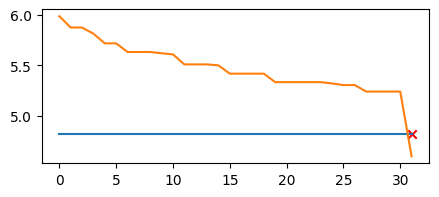

In [60]:
lo, hi = zip(*bounds)
i = list(range(len(bounds)))
plt.figure(figsize=(5,2))
plt.plot(i, x)
plt.plot(i, y);
plt.scatter(len(bounds)-1, sol.output, marker="x", color="red");

In [37]:
print("Maximum difference between instance0 and instance1")
if search.num_solutions() > 0:
    sol = s.get_solution(0)
    print("- current best solution:", sol.output, "->",
          "optimal" if s.is_optimal() else "suboptimal", "solution")
    # print("- feature value ranges", sol.box())
    print("- feature value ranges:")
    for key, interval in sol.box().items():
        print(f"  {feat_map.get_name(key):>24}: {interval}")

Maximum difference between instance0 and instance1
- current best solution: 7.088569953000006 -> optimal solution
- feature value ranges:
           checking_status: Interval(<1)
                  duration: Interval(<8)
            credit_history: Interval(>=4)
                   purpose: Interval(1,2)
             credit_amount: Interval(1107,1659)
            savings_status: Interval(>=2)
                employment: Interval(>=4)
    installment_commitment: Interval(>=3)
           personal_status: Interval(<1)
             other_parties: Interval(<2)
           residence_since: Interval(>=4)
        property_magnitude: Interval(<1)
                       age: Interval(>=67)
       other_payment_plans: Interval(>=2)
          existing_credits: Interval(>=2)
                       job: Interval(<3)
            foreign_worker: Interval(<1)
           personal_status: Interval(>=1)


In [38]:
new_instance = np.zeros((1, 20))
for i in range(20):
    if i in sol.box():
        interval = sol.box()[i]
        value = interval.hi - 1 if np.isinf(interval.lo) else interval.lo
        new_instance[0,i] = value
    else:
        new_instance[0,i] = 0

# new_instance = np.array([[0, 5, 4, 2, 1000, 4, 4, 4, pers_status, 1, 2, 0, 70, 1, 1, 0, 0, 0, 1, 0]])
for col in nonfixed_cols:
    for nb in (0, 1):
        i = feat_map.get_feat_id(col, nb)
        if i in sol.box():
            interval = sol.box()[i]
            value = interval.hi - 1 if np.isinf(interval.lo) else interval.lo
            print(f"Non fixed column {col} gets value {value}")
            i_mapped = X_df.columns.get_loc(col)
            new_instance[0,i_mapped] = value
        print(f"Instance: {new_instance}")
        prediction = model.predict(new_instance)[0]
        print(f"==> Prediction is {prediction}")

Non fixed column personal_status gets value 0.0
Instance: [[0.000e+00 7.000e+00 4.000e+00 1.000e+00 1.107e+03 2.000e+00 4.000e+00
  3.000e+00 0.000e+00 1.000e+00 4.000e+00 0.000e+00 6.700e+01 2.000e+00
  0.000e+00 2.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00]]
==> Prediction is 1
Non fixed column personal_status gets value 1.0
Instance: [[0.000e+00 7.000e+00 4.000e+00 1.000e+00 1.107e+03 2.000e+00 4.000e+00
  3.000e+00 1.000e+00 1.000e+00 4.000e+00 0.000e+00 6.700e+01 2.000e+00
  0.000e+00 2.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00]]
==> Prediction is 0
